# Simple Tensorflow Models

In this Notebook we will be working on some simple tensorflow models for the classification. We will try out:
- Baseline (a threshhold model to compare against)
- Feed-forward network
- LSTM network
- Auto-encoder for anomaly detection

## Setup of Data 

In [1]:
import os

import numpy  as np
import pandas as pd

import matplotlib.pyplot as plt


import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

# Colors using scheme
c = ["#" + i for i  in "264653-2a9d8f-e9c46a-f4a261-e76f51".split("-")]

2022-01-26 19:59:26.248633: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-26 19:59:26.248688: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
data_trace_high = pd.read_csv("/mnt/c/Users/johan/Desktop/CMT_project/data/traces_high.txt", sep = " ", header = None)
data_trace_low  = pd.read_csv("/mnt/c/Users/johan/Desktop/CMT_project/data/traces_low.txt",  sep = " ", header = None)

In [3]:
rand_seed  = 1969
test_split = 0.2


high_labels = np.ones(data_trace_high.shape[0])
low_labels  = np.zeros(data_trace_low.shape[0])

data        = pd.concat([data_trace_high, data_trace_low])
labels      = np.concatenate([high_labels,     low_labels])


X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size = test_split)

In [66]:
Y_train.shape

(16000,)

## Baseline Models
We will try to make some simple models, which we can use as a baseline which our Neural Networks have to compete with.

### Threshhold

Simple models reading out simple characteristics

In this model we simply look at timesteps between 50 and 100 and take the highest values. We will use that value as threshhold value in a ROC-curve

AUC score: 0.873


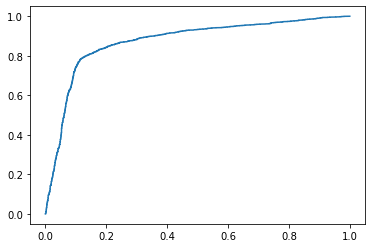

In [4]:
peak_height = X_test.iloc[:, 50:150].max(1)

roc         = roc_curve(Y_test, peak_height)
auc         = roc_auc_score(Y_test, peak_height)

plt.plot(roc[0], roc[1])

print(f"AUC score: {auc:.3f}")


### XGBoost
Pretty much a boosted decision tree from the box. 

In [5]:
from xgboost import XGBClassifier
from sklearn.preprocessing import RobustScaler

def preprocess_xgboost(df):
    data_fft = np.fft.rfft(df)

    fft_abs   = np.abs(data_fft)
    phase     = np.angle(data_fft)
    phase_cos = np.cos(phase)
    phase_sin = np.sin(phase) 

    data      = np.concatenate([df.to_numpy(), fft_abs, phase_cos, phase_sin], axis = 1)

    return data

xgboost_X_train = preprocess_xgboost(X_train)
xgboost_X_test  = preprocess_xgboost(X_test)


classifier      = XGBClassifier()


classifier.fit(xgboost_X_train, Y_train)


/home/johannbs/anaconda3/envs/tensorflow/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:59:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

0.8827627468157961


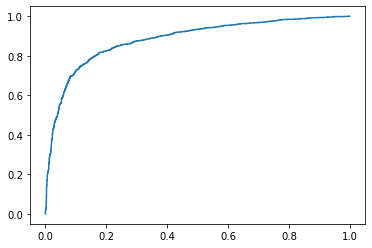

In [6]:
xgboost_scores = classifier.predict_proba(xgboost_X_test)

print(roc_auc_score(Y_test, xgboost_scores[:, 1]))


xgboost_roc = roc_curve(Y_test, xgboost_scores[:, 1])

plt.plot(xgboost_roc[0], xgboost_roc[1])

## Neural Network Models


### Simple Feed Forward

In [70]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()


X_train_scaled = np.expand_dims(scaler.fit_transform(X_train), -1)
X_test_scaled  = np.expand_dims(scaler.transform(X_test), -1)

In [101]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model
from tensorflow.keras.metrics import AUC, BinaryAccuracy
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

import tensorflow.keras.backend as K

In [103]:
from keras_lr_finder import LRFinder

from tensorflow.keras.layers import Bidirectional, LSTM, Dropout

In [109]:
hidden_states = 128
rnn_states    = 8
dropout       = 0.15
bi_directional  = True

epochs        = 10
batch_size    = 16
timesteps     = 220


input = Input(shape = (timesteps, 1))

x  = Bidirectional(LSTM(rnn_states, return_sequences = True, dropout = dropout))(input)
x  = Bidirectional(LSTM(rnn_states, return_sequences = True, dropout = dropout))(x)
x  = Bidirectional(LSTM(rnn_states, return_sequences = True, dropout = dropout))(x)

# x = GRU(rnn_states, input_shape = (timesteps, 1), return_sequences = True, activation = "tanh")(input)

x = tf.reshape(x, (-1, rnn_states * timesteps * (1 + bi_directional)))

x    = Dense(hidden_states)(x)
x    = Dropout(dropout)(x)
x    = Dense(hidden_states)(x)
x    = Dropout(dropout)(x)
x    = Dense(hidden_states)(x)
out  = Dense(1)(x)

model = Model(inputs = input, outputs = out)


optimizer = Adam(learning_rate = 3e-2, decay = 1e-5)

model.compile(  loss      = BinaryCrossentropy(from_logits = True),
                metrics   = [BinaryAccuracy(name = "Acc", threshold=0), AUC(name = "AUC", from_logits = True)],
                optimizer = "adam")


# finder = LRFinder(model)

# finder.find(X_train_scaled, Y_train, 1e-7, 1e-1, batch_size = batch_size)
# finder.plot_loss()

model.summary()



Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_43 (InputLayer)       [(None, 220, 1)]          0         
                                                                 
 bidirectional_16 (Bidirecti  (None, 220, 16)          640       
 onal)                                                           
                                                                 
 bidirectional_17 (Bidirecti  (None, 220, 16)          1600      
 onal)                                                           
                                                                 
 bidirectional_18 (Bidirecti  (None, 220, 16)          1600      
 onal)                                                           
                                                                 
 tf.reshape_16 (TFOpLambda)  (None, 3520)              0         
                                                          

In [110]:
K.set_value(model.optimizer.learning_rate, 1e-2)

model.fit(X_train_scaled, Y_train, epochs = epochs, batch_size = batch_size, validation_split = 0.1)
model.evaluate(X_test_scaled, Y_test)

Epoch 1/10
900/900 [==============================] - 201s 216ms/step - loss: 0.5832 - Acc: 0.7696 - AUC: 0.8234 - val_loss: 0.4281 - val_Acc: 0.8313 - val_AUC: 0.8901
Epoch 2/10
900/900 [==============================] - 260s 288ms/step - loss: 0.4425 - Acc: 0.8232 - AUC: 0.8784 - val_loss: 0.4847 - val_Acc: 0.8100 - val_AUC: 0.8955
Epoch 3/10
900/900 [==============================] - 259s 288ms/step - loss: 0.4239 - Acc: 0.8368 - AUC: 0.8855 - val_loss: 0.4056 - val_Acc: 0.8519 - val_AUC: 0.9024
Epoch 4/10
900/900 [==============================] - 386s 429ms/step - loss: 0.4067 - Acc: 0.8437 - AUC: 0.8934 - val_loss: 0.4135 - val_Acc: 0.8369 - val_AUC: 0.8966
Epoch 5/10
900/900 [==============================] - 236s 262ms/step - loss: 0.4123 - Acc: 0.8424 - AUC: 0.8927 - val_loss: 0.4970 - val_Acc: 0.8413 - val_AUC: 0.9012
Epoch 6/10
900/900 [==============================] - 246s 274ms/step - loss: 0.4077 - Acc: 0.8438 - AUC: 0.8932 - val_loss: 0.3869 - val_Acc: 0.8481 - val_AUC:

[0.3889538049697876, 0.8460000157356262, 0.9050827622413635]